### 인물 사진을 만들어 보자 
#### 인물 사진 모드 

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(721, 720, 3)


In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


(721, 720, 3)


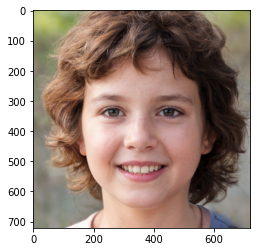

(0.0, 256.0)

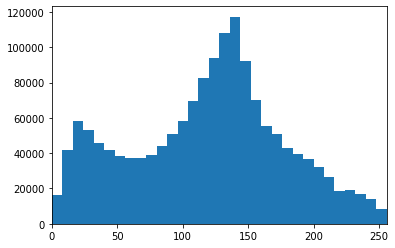

In [5]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.png'   
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()
fig, ax = plt.subplots(1, 1)
ax.hist(img_orig.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

In [6]:
# 준비한 이미지를 네트워크에 입력
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(721, 720, 3) (513, 512, 3) 15


In [7]:
# DeepLab의 PASCAL VOC 라벨

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

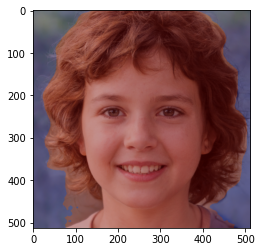

In [8]:
# 세그멘테이션

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)  # 색 적용
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

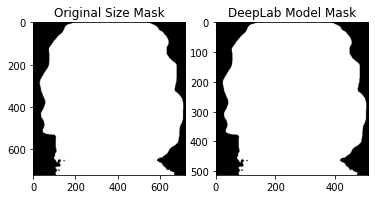

In [9]:
# 세그멘테이션 결과(mask)를 원래 크기로 복원
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

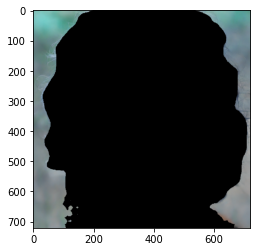

In [10]:
# 세그멘테이션 마스크를 이용하여 배경만 추출

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)       #이미지 반전! 배경은 255, 사람이 0
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)     #배경만 있는 연산 get

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

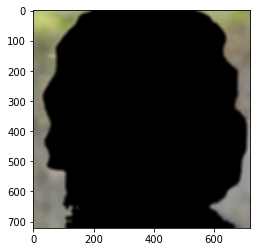

In [11]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

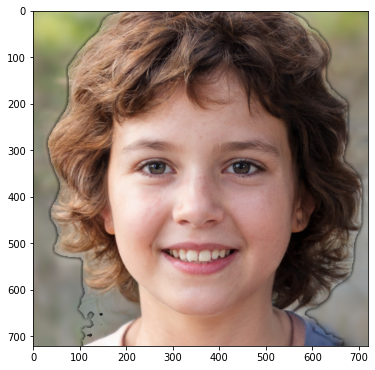

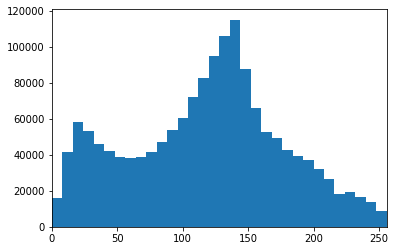

In [12]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('re_my_image.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

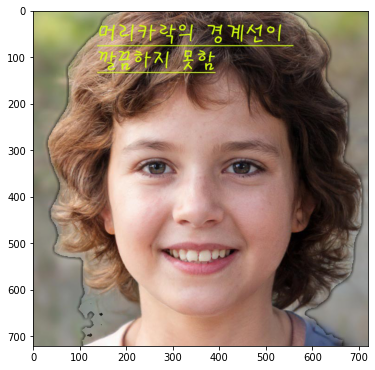

In [13]:
a1 = plt.imread('re_my_image2.jpg')
plt.figure(figsize=(6,8))
plt.imshow(a1)

#### 사진의 문제점 : 머리카락의 경셰선이 깔끔하게 정리 되지 못했다. 

### 고양이 사진모드

(450, 721, 3)


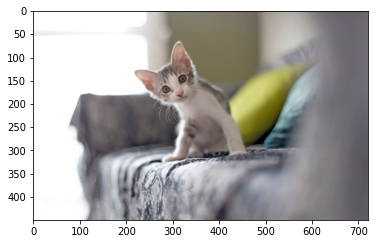

(0.0, 256.0)

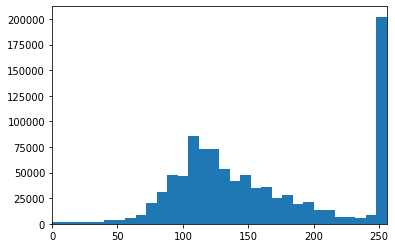

In [14]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_cat.png'   
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()
fig, ax = plt.subplots(1, 1)
ax.hist(img_orig.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

In [15]:
# 준비한 이미지를 네트워크에 입력
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(450, 721, 3) (320, 513, 3) 8


In [16]:
# DeepLab의 PASCAL VOC 라벨

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

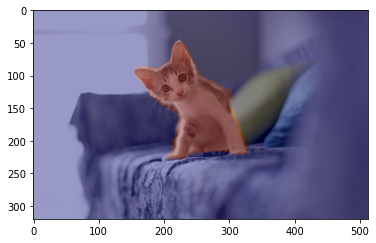

In [17]:
# 세그멘테이션

img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)  # 색 적용
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

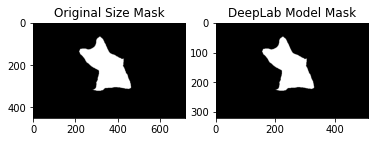

In [18]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

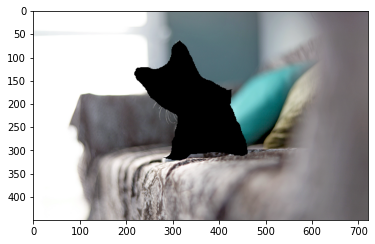

In [19]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

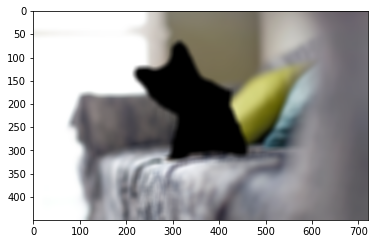

In [20]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

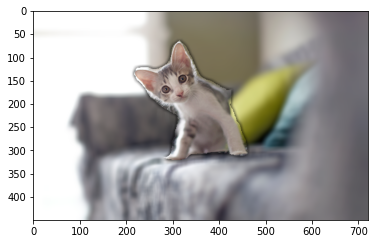

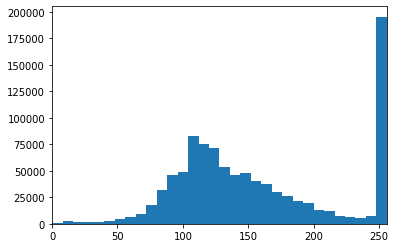

In [21]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('re_my_cat.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

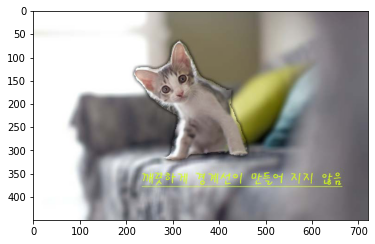

In [22]:
d1 = plt.imread('re_my_cat2.jpg')
plt.figure(figsize=(6,8))
plt.imshow(d1)

#### 사진의 문제점 : 고양이의 털부분의 경셰선이 깔끔하게 정리 되지 못했다. 

### 고양이 사진 크로마키

(408, 612, 3)


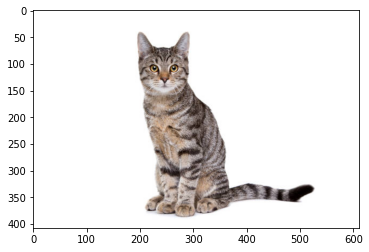

(0.0, 256.0)

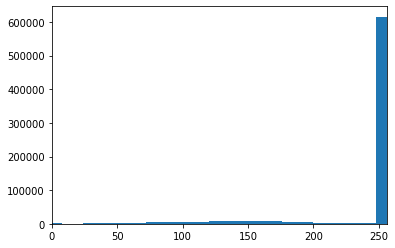

In [23]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_cat2.jpg'   
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()
fig, ax = plt.subplots(1, 1)
ax.hist(img_orig.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

In [24]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(408, 612, 3) (342, 513, 3) 8


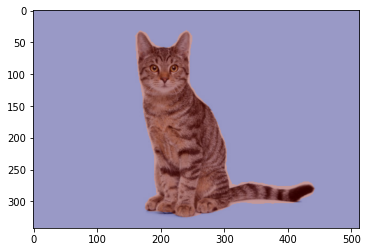

In [25]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

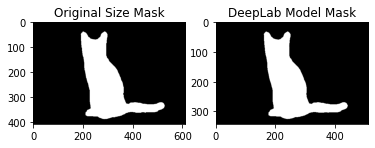

In [26]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

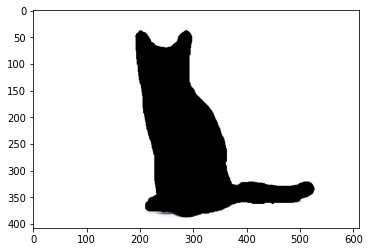

In [27]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

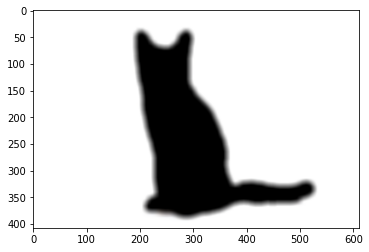

In [28]:
img_bg_blur = cv2.blur(img_bg, (13,13))
#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

(0.0, 256.0)

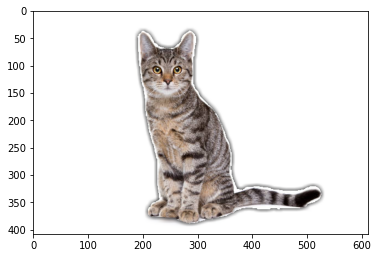

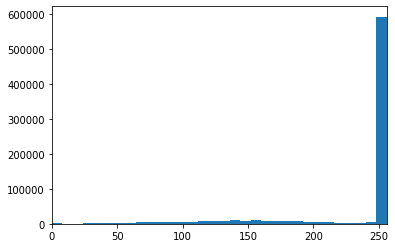

In [29]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
#img_h = cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)
cv2.imwrite('cat2_인물모드.jpg', img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
fig, ax = plt.subplots(1, 1)
ax.hist(img_concat.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256)

In [30]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_cat2.jpg'   
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(408, 612, 3)


In [31]:
bg_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_cat_bg.png'   
bg_orig = cv2.imread(bg_path) 
print (bg_orig.shape)

(678, 960, 3)


In [32]:
img_orig = cv2.resize(img_orig, (960, 678)) # 풍경 사이즈와 맞게 resize

In [33]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(678, 960, 3) (362, 513, 3) 8


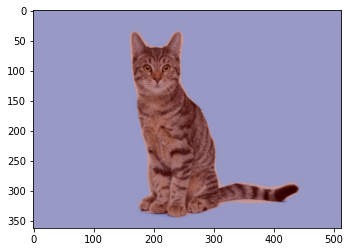

In [34]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

#plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

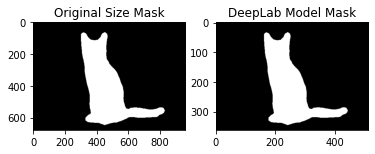

In [35]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

#plt.figure(figsize=(10,13))
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

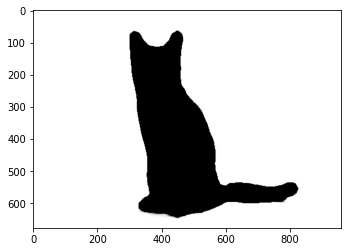

In [36]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

#plt.figure(figsize=(6,8))
plt.imshow(img_bg)
plt.show()

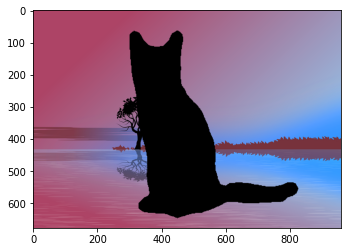

In [37]:
img_concat = np.where(img_bg==0, img_bg, bg_orig)
plt.imshow(img_concat)
plt.show()

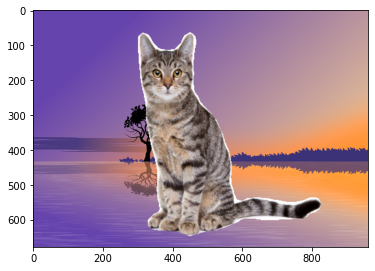

In [38]:
cromakey = np.where(img_mask_color==255, img_orig, img_concat)
plt.figure(figsize=(6,8))
plt.imshow(cv2.cvtColor(cromakey, cv2.COLOR_BGR2RGB))
plt.show()

### 느낀점 

#### 결과 적으로 사진의 인물이나 고양이는 잘 인식 되었지만 고양이의 경우 얼굴만 나온다거나 절반만 나오는 경우
#### 잘 인식하지 않은 경우도 있었다. 
#### 경계선을 말끔하게 정리하고 싶었으나 아직까지 방법을 찾지 못하였고 조금더 시도 해보려고 한다. 